# Executive Summary
* Build predictive model to allieviate employee churn and overall employee satisfaction based on employee data available.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import PartialDependenceDisplay

from xgboost import plot_importance


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/hr-analytics-and-job-prediction/HR_comma_sep.csv


In [2]:
data = pd.read_csv('/kaggle/input/hr-analytics-and-job-prediction/HR_comma_sep.csv')

In [3]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# Data Processing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
data = data.rename(columns={'number_project':'n_projects',
                            'average_montly_hours':'avg_monthly_hrs',
                            'time_spend_company':'tenure',
                            'Work_accident':'work_accident',
                            'Department':'department'})
##renaming columns for intelligibility

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   n_projects             14999 non-null  int64  
 3   avg_monthly_hrs        14999 non-null  int64  
 4   tenure                 14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [7]:
data.isna().sum()

satisfaction_level       0
last_evaluation          0
n_projects               0
avg_monthly_hrs          0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [8]:
data_duplicates = data[data.duplicated()]
data_duplicates
##taking away duplicate rows to cleanup data

,satisfaction_level,last_evaluation,n_projects,avg_monthly_hrs,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [9]:
data_new = data.drop(index=data_duplicates.index)
data_new.head()

,satisfaction_level,last_evaluation,n_projects,avg_monthly_hrs,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


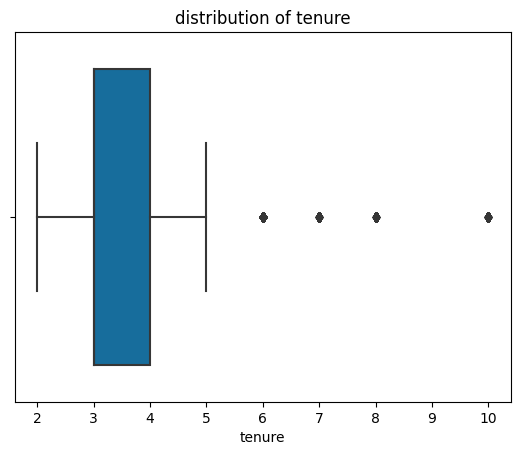

<Figure size 25x25 with 0 Axes>

In [10]:
## checking for potential outliers
bx = sns.boxplot(data=data_new, x='tenure', palette='colorblind')
plt.figure(figsize=(.25,.25))
bx.set_xlabel('tenure')
bx.set_title('distribution of tenure')
plt.show()

In [11]:
q1 = data_new['tenure'].quantile(.25)
q3 = data_new['tenure'].quantile(.75)

iqr = q3 - q1
upper_limit = q3 + 1.5 * iqr
lower_limit = q1 - 1.5 * iqr

outliers = data_new[(data_new['tenure']<lower_limit) | (data_new['tenure']>upper_limit)]
outliers['tenure'].count()
##using iqr to determine outlier values

824

In [12]:
data_new['left'].value_counts(normalize=True)

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

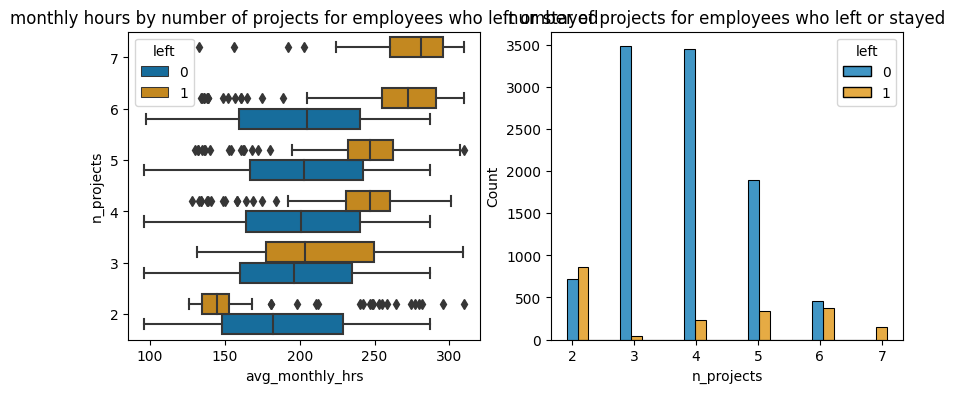

In [13]:
##EDA
fig,ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=data_new, x='avg_monthly_hrs', y='n_projects', hue='left', orient='h', palette='colorblind', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('monthly hours by number of projects for employees who left or stayed')
tenure_stay = data_new[data_new['tenure']==1]['n_projects']
tenure_leave = data_new[data_new['tenure']==0]['n_projects']
sns.histplot(data=data_new, x='n_projects', hue='left', multiple='dodge', shrink=2, palette='colorblind', ax=ax[1])
ax[1].set_title('number of projects for employees who left or stayed')
plt.show()
##we can see that distribution of avg hours increase over projects with particular interest in n=7 projects. It only consists of employees who left the company. This is valuable insight and useful as a independent variable in the model

In [14]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     11991 non-null  float64
 1   last_evaluation        11991 non-null  float64
 2   n_projects             11991 non-null  int64  
 3   avg_monthly_hrs        11991 non-null  int64  
 4   tenure                 11991 non-null  int64  
 5   work_accident          11991 non-null  int64  
 6   left                   11991 non-null  int64  
 7   promotion_last_5years  11991 non-null  int64  
 8   department             11991 non-null  object 
 9   salary                 11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.0+ MB


# Descriptive Statistics

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


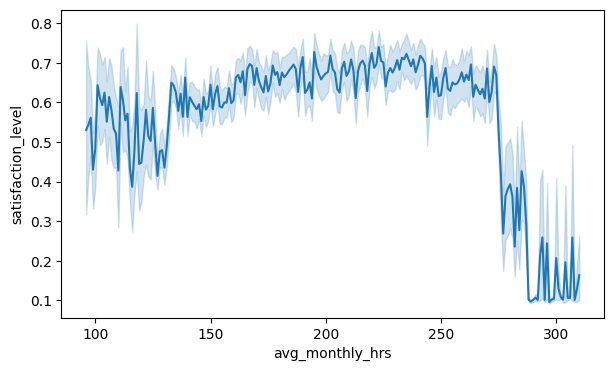

In [15]:
plt.figure(figsize=(7,4))
sns.lineplot(data=data_new, x='avg_monthly_hrs', y='satisfaction_level')
plt.show()
#average satisfaction level drops significantly after 260-270 monthly hours

Text(0.5, 1.0, 'distribution of satisfaction across salary groups')

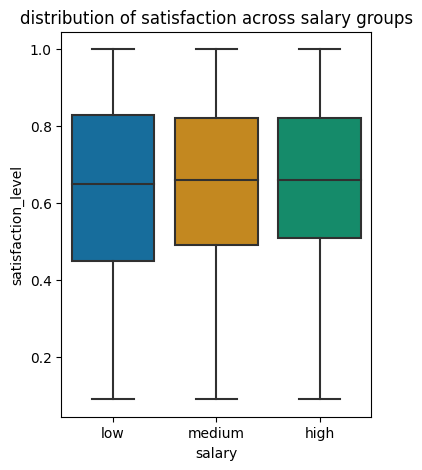

In [16]:
plt.figure(figsize=(4,5))
viz = sns.boxplot(data=data_new, x='salary', y='satisfaction_level', palette='colorblind')
viz.set_title('distribution of satisfaction across salary groups')
#the 50th percentile sits around 60 percent satisfaction across salary groups. There is no siginicant difference between the distribution per salary groups

Text(0.5, 1.0, 'distribution of satisfaction for employees who left vs stayed')

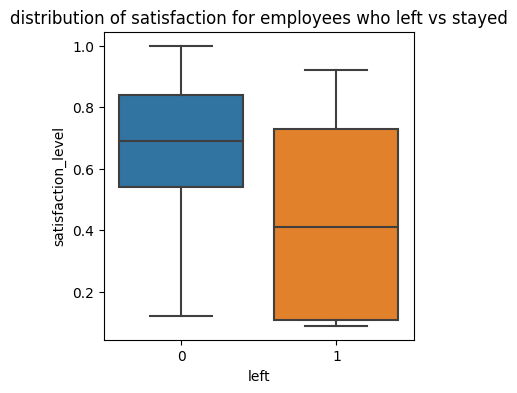

In [17]:
plt.figure(figsize=(4,4))
sns.boxplot(data=data_new, x='left', y='satisfaction_level')
plt.title('distribution of satisfaction for employees who left vs stayed')
## satisfaction level signficant skewed for employees who left. This enforces the value of satisfaction as an independent variable

/tmp/ipykernel_18/3521138827.py:7: FutureWarning: The provided callable <function mean at 0x7ad52c3c3d90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  print(data_new.groupby(by='left')['satisfaction_level'].agg([np.mean, np.median]))
/tmp/ipykernel_18/3521138827.py:7: FutureWarning: The provided callable <function median at 0x7ad52c0b3490> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  print(data_new.groupby(by='left')['satisfaction_level'].agg([np.mean, np.median]))


          mean  median
left                  
0     0.667365    0.69
1     0.440271    0.41


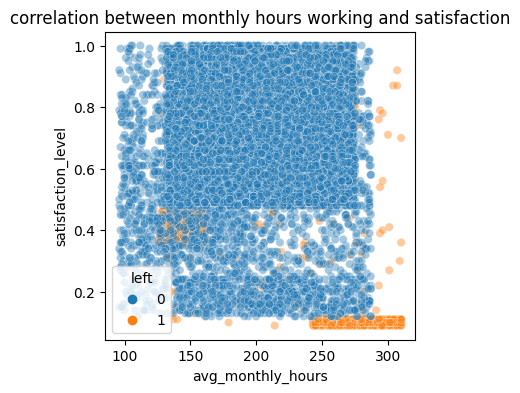

In [18]:
plt.figure(figsize=(4,4))
sns.scatterplot(data=data_new, x='avg_monthly_hrs', y='satisfaction_level', hue='left', alpha=.4)
plt.xlabel('avg_monthly_hours')
plt.ylabel('satisfaction_level')
plt.title('correlation between monthly hours working and satisfaction')
##there's a large group of employees who left and who had low satisfaction and worked 250+ hours. that is worth looking into. The average satisfaction for employees who left is almost 20% less
print(data_new.groupby(by='left')['satisfaction_level'].agg([np.mean, np.median]))


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

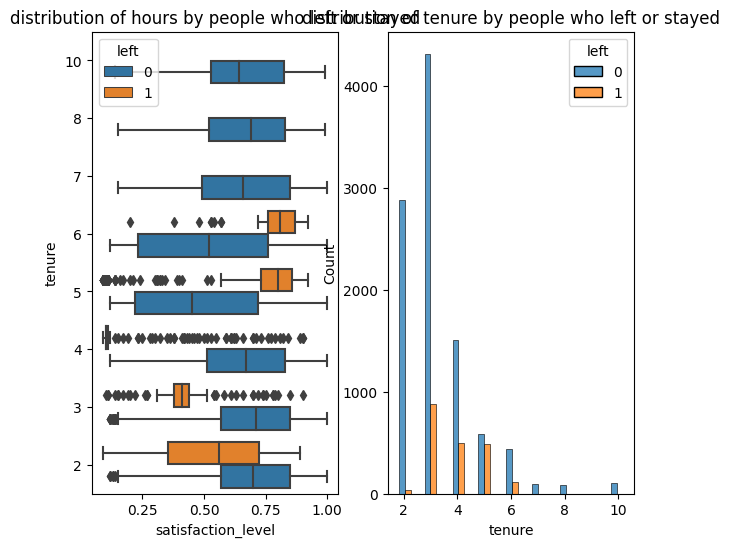

In [19]:
fig, ax = plt.subplots(1,2, figsize=(7,6))
sns.boxplot(data=data_new, x='satisfaction_level', y='tenure', hue='left', orient='h', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('distribution of hours by people who left or stayed')
tenure_stay = data_new[data_new['tenure']==0]['tenure']
tenure_left = data_new[data_new['tenure']==1]['tenure']
sns.histplot(data=data_new, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('distribution of tenure by people who left or stayed')
plt.show()
##we can see that after 7 years of tenure, employees left. Will further explore whether it was impacted by salary or not in the next cell

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

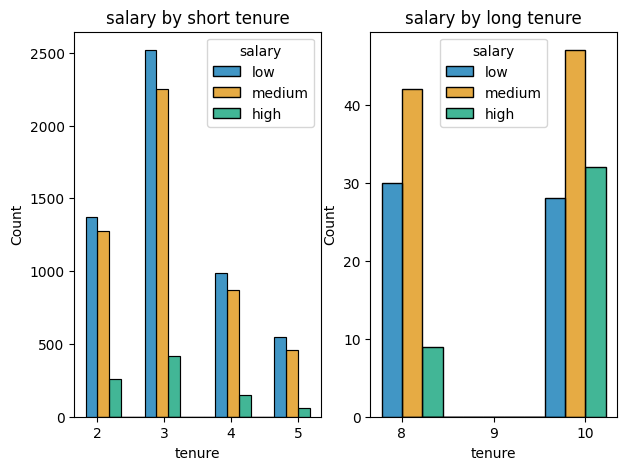

In [20]:
##exploring the reasonwhy tenure after 7 years only includes employees who left
short_tenure = data_new[data_new['tenure']<6]
long_tenure = data_new[data_new['tenure']>7]
fig, ax = plt.subplots(1,2, figsize=(7,5))
sns.histplot(data=short_tenure, x='tenure', hue='salary', hue_order=['low','medium','high'], multiple='dodge', palette='colorblind', ax=ax[0], shrink=3)
sns.histplot(data=long_tenure, x='tenure', hue='salary', hue_order=['low','medium','high'], multiple='dodge', palette='colorblind', ax=ax[1], shrink=3)
ax[0].set_title('salary by short tenure')
ax[1].set_title('salary by long tenure')
plt.show()
##the graph below indicates that long tenure did not have disprortionate % of high salary earners

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

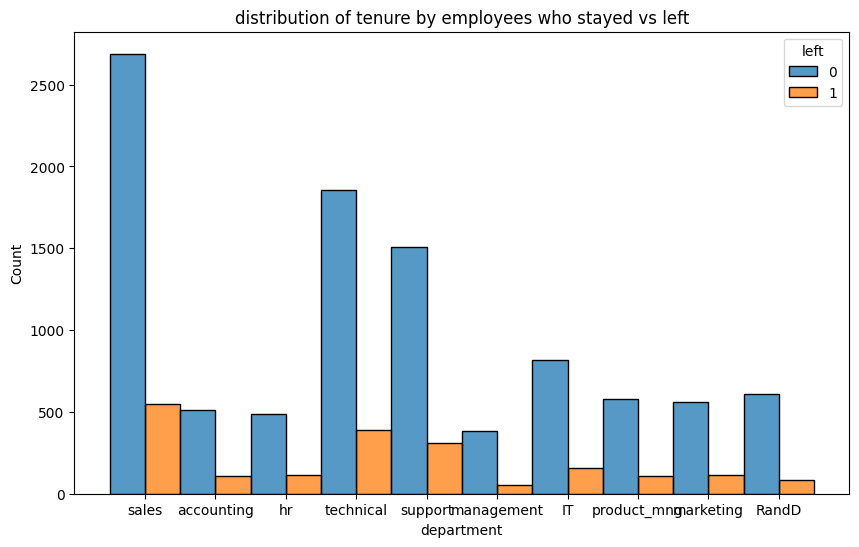

In [21]:
plt.figure(figsize=(10,6))
sns.histplot(data=data_new, x='department', hue='left', multiple='dodge', hue_order=[0,1])
plt.xlabel('department')
plt.title('distribution of tenure by employees who stayed vs left')
plt.show()

Text(0.5, 1.0, 'heatmap of correlation between variables')

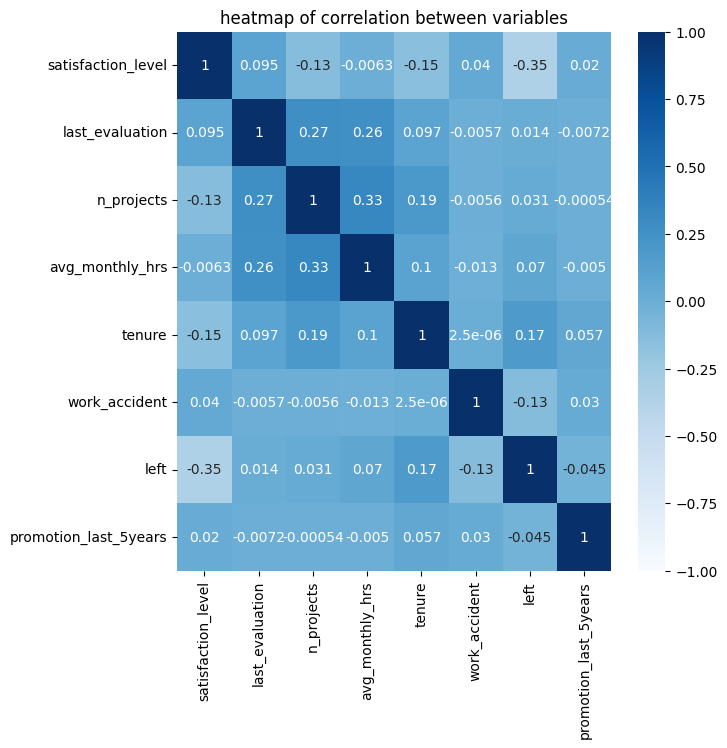

In [22]:
plt.figure(figsize=(7,7))
sns.heatmap(data=data_new.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette(palette='Blues', as_cmap=True))
plt.title('heatmap of correlation between variables')
##identifying the variables that may inform which variables are best suited for analysis

# Predictive Modeling

In [23]:
##setting up variables for my random forest classifier
x = data_new.drop(columns='left')
y = data_new['left']
x['salary'] = x['salary'].map({'low':0,'medium':1,'high':2})
x['salary'] = x['salary'].astype(np.int8)
x = pd.get_dummies(x, dtype=np.int8, drop_first=False)
x.head()

,satisfaction_level,last_evaluation,n_projects,avg_monthly_hrs,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0


In [24]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.2, stratify=y, random_state=42)
rf = RandomForestClassifier(random_state=42)

#hyperparameter tuning
cv_params = {'max_depth': [3,5,None],
            'max_features': [1.0],
            'max_samples': [0.7,1.0],
            'min_samples_leaf': [1,2,3],
            'min_samples_split': [2,3,4],
            'n_estimators': [300],
            }

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [25]:
%%time
rf1.fit(x_train, y_train)

CPU times: user 11min 22s, sys: 1.16 s, total: 11min 23s
Wall time: 11min 23s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300]},
             refit='roc_auc',
             scoring={'roc_auc', 'accuracy', 'recall', 'precision', 'f1'})

In [26]:
print('rf1 best score:', rf1.best_score_, '\n',
    'rf1 best params:', rf1.best_params_)

rf1 best score: 0.9808798926842641 
 rf1 best params: {'max_depth': None, 'max_features': 1.0, 'max_samples': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}


In [27]:
def make_results(model_name:str, model_object, metric:str):
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    cv_results = pd.DataFrame(model_object.cv_results_)

    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'accuracy': [accuracy],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1]},
                       )

    return table

results = make_results('RF CV', rf1, 'f1')
results

,model,accuracy,precision,recall,F1
0,RF CV,0.983945,0.983236,0.919017,0.950033


In [28]:
y_pred = rf1.best_estimator_.predict(x_test)

def get_test_scores(model_name:str, y_pred, y_test):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

rf_test_scores = get_test_scores('RF test', y_pred, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,accuracy,precision,recall,F1
0,RF CV,0.983945,0.983236,0.919017,0.950033
0,RF test,0.986244,0.989276,0.927136,0.957198


In [29]:
##comparing random forest classifier against a decision tree 
tree = DecisionTreeClassifier(random_state=1)
cv_params = {'max_depth': [4,6,8, None],
          'min_samples_leaf': [2,5,1],
          'min_samples_split': [2,4,6]}
scoring = {'accuracy', 'precision', 'recall','f1','roc_auc'}
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [30]:
%%time
tree1.fit(x_train, y_train)

CPU times: user 4.6 s, sys: 0 ns, total: 4.6 s
Wall time: 4.6 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'roc_auc', 'accuracy', 'recall', 'precision', 'f1'})

In [31]:
y_pred_tree = tree1.predict(x_test)
dt_test_scores = get_test_scores('DT test', y_pred_tree, y_test)
results = pd.concat([results, dt_test_scores], axis=0)
results.sort_values(by=['F1'], ascending=False)
#the random forest outperforms the single decision tree. The random forest test set improves the f1 score by almost 1% across all performance metrics
#the decision tree did compute at half the speed. This may be a factor if this was a larger data set and computational cost was a factor

,model,accuracy,precision,recall,F1
0,RF test,0.986244,0.989276,0.927136,0.957198
0,RF CV,0.983945,0.983236,0.919017,0.950033
0,DT test,0.983743,0.973615,0.927136,0.949807


Text(0.5, 1.0, 'confusion matrix to visualize how well the model predicted values')

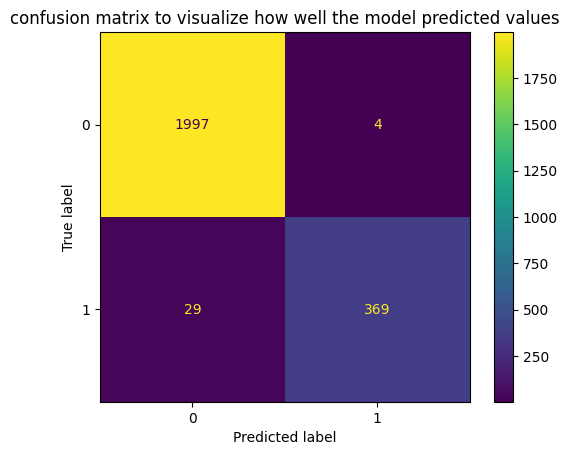

In [32]:
cm = metrics.confusion_matrix(y_test, y_pred, labels=rf1.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf1.classes_)
disp.plot(values_format='')
plt.title('confusion matrix to visualize how well the model predicted values')
##the confusion matrix indicates that a large proportion of values were accurately predicted for individuals who would leave and have left. Likewise, for those who have stayed

Text(0.5, 1.0, 'feature engineering by highest gini score')

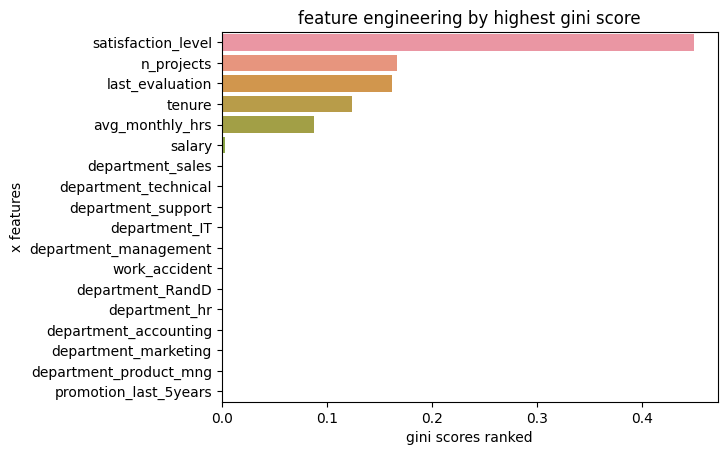

In [33]:
##feature importance engineering based on gini impurity scores
rf1_importances = pd.DataFrame(rf1.best_estimator_.feature_importances_,
                                  columns=['gini_importance'],
                              index=x.columns)
rf1_importances = rf1_importances[rf1_importances['gini_importance']>0].sort_values(by='gini_importance', ascending=False)
vis = sns.barplot(data=rf1_importances, x='gini_importance', y=rf1_importances.index, orient='h')
vis.set_ylabel('x features')
vis.set_xlabel('gini scores ranked')
vis.set_title('feature engineering by highest gini score')
#this indicates that number of projects and avg monthly hours spent working largely influenced if employees left or stayed. satisifaction level in the surveys also we

<Figure size 1100x1100 with 0 Axes>

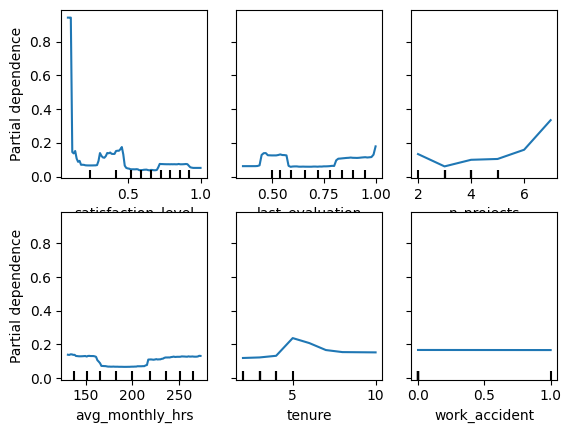

In [34]:
plt.figure(figsize=(11,11))
PartialDependenceDisplay.from_estimator(rf1, x_train, range(6))
##reviewing the partial dependence for features with a gini score above 0. 

In [35]:
results.sort_values(by='F1', ascending=False)

,model,accuracy,precision,recall,F1
0,RF test,0.986244,0.989276,0.927136,0.957198
0,RF CV,0.983945,0.983236,0.919017,0.950033
0,DT test,0.983743,0.973615,0.927136,0.949807


# Results
* Overall, choosing a random forest classifier has yielded a strong predictive model.  Our test samples have been predicted with 98.6% accuracy and the f1 score has increased by 0.7% from cross validation.This was a result of using GridSearchCV for cross-validation.
* Top 5 features had noticable importance as predictors in employees who left or stayed. Reducing projects and avg monthly hours are quick wins to improve satisifaction
* Seen in the scatterplot, satisfaction level significantly drops for employees who worked 250+ monthly avg hours. Reducing avg monthly hours to below 250 may lead to improved satisfaction at work. 
* The distribution of employees with 7 projects consisted of all employees who left. Reducing project ownership to less than 7 will also improve company churn. This is the second most important feature based on gini scores. Looking at partial dependence, n_projects starts to show an increasing relationship with employees leaving starting at n_projects=5. Management should consider reducing projects to less than 5 projects specifically.
* Followup surveys for satisfaction levels after achieving quick wins will be necessary to re-evaluate it is the most important feature to predicting if employees leave or not.